In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text
from pprint import pprint



# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

# reflect the tables
metadata = sqlalchemy.MetaData()
metadata.reflect(bind=engine)

Base = automap_base(metadata=metadata)
Base.prepare()


In [7]:
# View all of the classes that automap found
class_names = Base.classes.keys()
print("Classes found by automap:", class_names)


Classes found by automap: ['measurement', 'station']


In [8]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement



In [9]:
# Create our session (link) from Python to the DB

Session = sessionmaker(bind=engine)
session = Session()


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()

print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


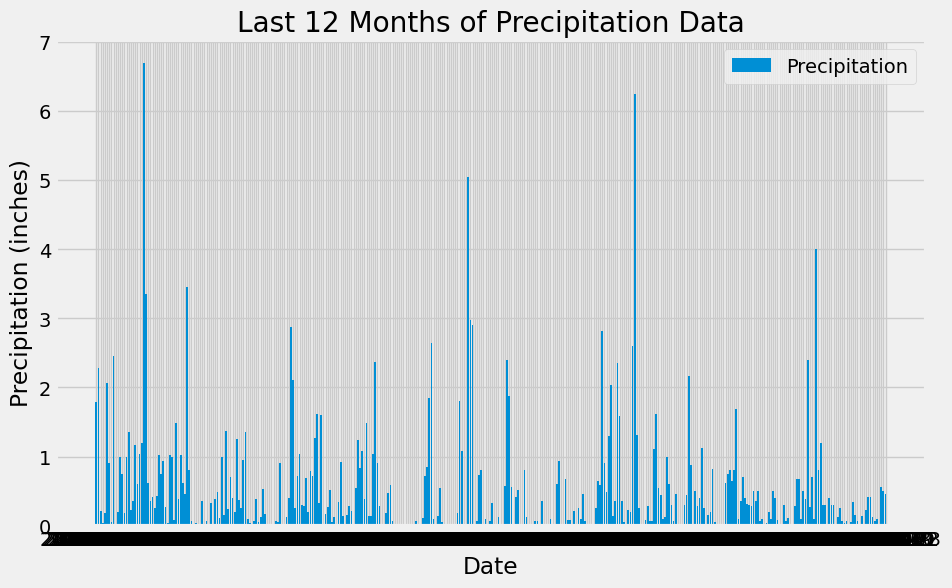

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the most recent date in the data set
most_recent_date = session.query(func.max(measurement.date)).scalar()

# Convert most_recent_date to a datetime object
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate one year ago from the most recent date
one_year_ago = most_recent_date - pd.DateOffset(years=1)

one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores for the last 12 months
results = session.query(measurement.date, measurement.prcp)\
                  .filter(text(f"{measurement.date} >= :one_year_ago"))\
                  .params(one_year_ago=one_year_ago_str)\
                  .order_by(measurement.date)\
                  .all()

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['date'], df['precipitation'], label='Precipitation')
plt.title('Last 12 Months of Precipitation Data')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.legend()
plt.tight_layout
plt.show()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Calculate summary statistics for the precipitation column
summary_stats = df['precipitation'].describe()

summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.station))\
                         .group_by(measurement.station)\
                         .order_by(func.count(measurement.station).desc())\
                         .all()

# Print the results
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_id = 'USC00519281'

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs))\
                           .filter(measurement.station == active_station_id)\
                           .all()
                           
print(f"Temperature Statistics for Station {active_station_id}:")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


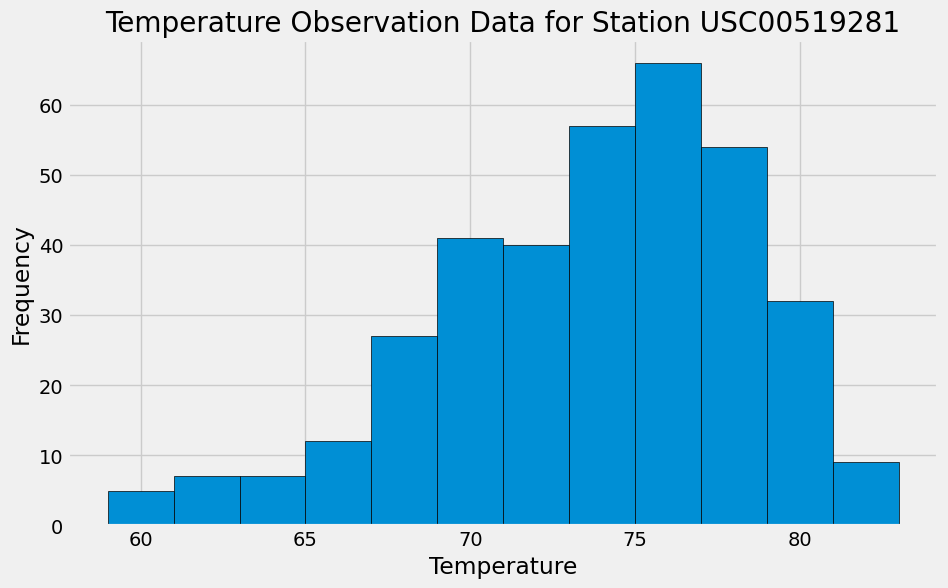

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

specific_station_id = 'USC00519281'

# Calculate the date one year from the most recent date in the data set
most_recent_date = session.query(func.max(measurement.date))\
                          .filter(measurement.station == specific_station_id)\
                          .scalar()

# Convert most_recent_date to a datetime object
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate one year ago from the most recent date
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Convert one_year_ago to a string
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the last 12 months of temperature observation data for the specified station
results = session.query(measurement.date, measurement.tobs)\
                  .filter(measurement.station == specific_station_id)\
                  .filter(measurement.date >= one_year_ago_str)\
                  .order_by(measurement.date)\
                  .all()

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(results, columns=['date', 'temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['temperature'], bins=12, edgecolor='black')
plt.title(f'Temperature Observation Data for Station {specific_station_id}')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [17]:
# Close Session
session.close()

In [3]:
from flask import Flask, jsonify
import datetime as dt
from sqlalchemy import create_engine, func, inspect


# Create a Flask app
app = Flask(__name__)

# Create a route for the homepage
@app.route('/')
def home():
    return (
        f"Welcome to the Climate Analysis API!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/start<br/>"
        f"/api/v1.0/start/end"
    )

# Create a route for precipitation data
@app.route('/api/v1.0/precipitation')
def precipitation():
    most_recent_date = session.query(func.max(measurement.date)).scalar()
    most_recent_date = pd.to_datetime(most_recent_date)
    one_year_ago = most_recent_date - pd.DateOffset(years=1)
    
    results = session.query(measurement.date, measurement.prcp)\
                    .filter(measurement.date >= one_year_ago)\
                    .order_by(measurement.date)\
                    .all()

    precipitation_data = {date: prcp for date, prcp in results}

    return jsonify(precipitation_data)

# Create a route for station data
@app.route('/api/v1.0/stations')
def stations():
    stations = session.query(measurement.station).all()
    station_list = [station[0] for station in stations]

    return jsonify(station_list)

# Create a route for temperature observations
@app.route('/api/v1.0/tobs')
def tobs():
    specific_station_id = 'USC00519281'
    most_recent_date = session.query(func.max(measurement.date))\
                              .filter(measurement.station == specific_station_id)\
                              .scalar()
    most_recent_date = pd.to_datetime(most_recent_date)
    one_year_ago = most_recent_date - pd.DateOffset(years=1)

    results = session.query(measurement.date, measurement.tobs)\
                    .filter(measurement.station == specific_station_id)\
                    .filter(measurement.date >= one_year_ago)\
                    .order_by(measurement.date)\
                    .all()

    tobs_data = [{'date': date, 'temperature': tobs} for date, tobs in results]

    return jsonify(tobs_data)

# Create a route for temperature statistics for a specified start or start-end range
@app.route('/api/v1.0/<start>')
def temperature_stats_start(start):
    results = session.query(func.min(measurement.tobs),
                             func.avg(measurement.tobs),
                             func.max(measurement.tobs))\
                     .filter(measurement.date >= start)\
                     .all()

    temperature_stats = [{'TMIN': result[0], 'TAVG': result[1], 'TMAX': result[2]} for result in results]

    return jsonify(temperature_stats)

# Create a route for temperature statistics for a specified start-end range
@app.route('/api/v1.0/<start>/<end>')
def temperature_stats_start_end(start, end):
    results = session.query(func.min(measurement.tobs),
                             func.avg(measurement.tobs),
                             func.max(measurement.tobs))\
                     .filter(measurement.date >= start)\
                     .filter(measurement.date <= end)\
                     .all()

    temperature_stats = [{'TMIN': result[0], 'TAVG': result[1], 'TMAX': result[2]} for result in results]

    return jsonify(temperature_stats)

# Run the app
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat
Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/codespace/.python/current/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/codespace/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/home/codespace/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 654, in initialize
    self.init_sockets()
  File "/home/codespace/.local/lib/python3.10/site-p

SystemExit: 1